In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
raw = pd.ExcelFile('Crime.xls')

In [3]:
df = raw.parse('13tbl8ny')

In [4]:
df = df.drop(df.index[[0,1,2,3]])

In [5]:
df.drop('Unnamed: 4', axis=1, inplace=True)

In [6]:
df.rename(columns={'Table 8': 'City', 'Unnamed: 1': 'Population', 'Unnamed: 2': 'Violent Crime', 'Unnamed: 5': 'Murder/Manslaughter'}, inplace=True)

In [7]:
df.rename(columns={'Unnamed: 3': 'Murder', 'Murder/Manslaughter': 'Rape', 'Unnamed: 6': 'Robbery', 
                'Unnamed: 7': 'Aggravated Assault', 'Unnamed: 8': 'Property Crime', 'Unnamed: 9': 'Burglary',
                'Unnamed: 10': 'Larceny-Theft', 'Unnamed: 11': 'Motor Vehicle Theft', 'Unnamed: 12': 'Arson'  }, inplace=True)

In [8]:
df = df.drop(df.index[[349,350,348]])

In [9]:
df['Population']= df['Population'].astype(int)

In [10]:
df = df[df['Population'] < 100000]

In [11]:
df['Population_2'] = df['Population']**2

In [12]:
df['Property Crime']= df['Property Crime'].astype(int)

In [13]:
df['Population_2'] = df['Population_2'].astype(int)

In [14]:
df['Robbery'] = df.Robbery.apply(lambda x: 0 if x== 0 else 1)

In [15]:
df['Murder'] = df.Murder.apply(lambda x: 0 if x== 0 else 1)

### Previous Work
All this work had been previously done in the prior projects. Here we took the data set, cleaned it, and changed the columns to reflect the data better. We removed any outliers of populations over 100000 people and converted all of the data to integers. Finally we became unconcerned with the amount of murders and robberies rather just factoring in whether murders or robberies took place. Our first model was as follows.

In [16]:
regr = linear_model.LinearRegression()
Y = df['Property Crime']
X = df[['Murder', 'Robbery', 'Population', 'Population_2' ]]
regr.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print('\nCoefficients: \n', np.round(regr.coef_,decimals=2))
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
pd.set_option('display.precision', 2)


Coefficients: 
 [  1.57350000e+02   3.76500000e+01   2.00000000e-02  -0.00000000e+00]

Intercept: 
 -58.923204464

R-squared:
0.734711719065


By changing the objects to integers we received coefficients that made logical sense yet our R-squared decreased as was seen in the previous model. The first decision we decide to make here is to try and eliminate the Population squared feature as it has no impact on the model. 

In [18]:
regr = linear_model.LinearRegression()
Y = df['Property Crime']
X = df[['Murder', 'Robbery', 'Population', ]]
regr.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
print('\nCoefficients: \n', np.round(regr.coef_,decimals=2))
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
pd.set_option('display.precision', 2)


Coefficients: 
 [  1.64080000e+02   3.02100000e+01   2.00000000e-02]

Intercept: 
 -58.8428579548

R-squared:
0.73155787327


Our R-squared decreases a little but we remove a seemingly uselss feature. Let's look at our columns to see if there are other features we can add that would make meaningful sense for our model.

In [20]:
list(df.columns.values)
#We predict Burglary can be good predictors of property crime. First we convert it to integers.

['City',
 'Population',
 'Violent Crime',
 'Murder',
 'Rape',
 'Robbery',
 'Aggravated Assault',
 'Property Crime',
 'Burglary',
 'Larceny-Theft',
 'Motor Vehicle Theft',
 'Arson',
 'Population_2']

In [21]:
df['Burglary']= df['Burglary'].astype(int)

In [32]:
regr = linear_model.LinearRegression()
Y = df['Property Crime']
X = df[['Murder', 'Robbery', 'Population','Burglary',]]
regr.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
print('\nCoefficients: \n', np.round(regr.coef_,decimals=2))
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
pd.set_option('display.precision', 2)


Coefficients: 
 [ -5.40500000e+01   2.82300000e+01   1.00000000e-02   3.39000000e+00]

Intercept: 
 -29.5736499864

R-squared:
0.925889009363


We have improved our model r-squared to 92.5889. Much better than our original model, however murder coefficient is negative. Let's run the correlation matrix to see if it is positively correlated with our desired outcome. 

In [34]:
df[['Population','Burglary', 'Property Crime', 'Murder', 'Robbery']].corr()

,Population,Burglary,Property Crime,Murder,Robbery
Population,1.000,0.723,0.849,0.470,0.443
Burglary,0.723,1.000,0.926,0.512,0.342
Property Crime,0.849,0.926,1.000,0.487,0.410
Murder,0.470,0.512,0.487,1.000,0.296
Robbery,0.443,0.342,0.410,0.296,1.000


Since negative coeffecient does not mean the model is incorrect we have improved our model significantly by doing a number of things. First, we made sure all data was either a float or integer. Next, we removed outliers to improve our model's accuracy. Then, we decided to remove the variable population_2 due to it having 0 coeffecient and very low impact on the model. Finally, we added the highly correlated Burglary variable which improved our R-Squared to a high number of 92.5%. Let's take one final look at the residuals to see where most of our errors fall.

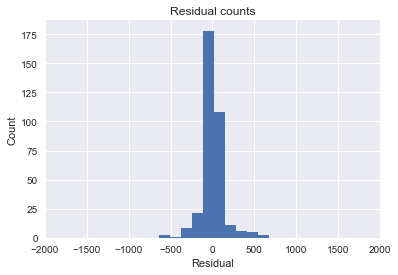

In [35]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Property Crime']
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlim(-2000,2000)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


Our Error looks extremely normal and almost all clustered around 0! A great success for our model. I am satisfied that using the  4 features of binary Murder and Robbery, and Burglary and population we have created a very good linear model.

In [80]:
#We will now preform a validation test
linear_formula = 'Property_Crime ~ Population+Burglary+Robbery+Murder'
data=df


In [81]:
lm = smf.ols(formula=linear_formula, data=data).fit()

In [82]:

lm.params

Intercept    -29.574
Population     0.011
Burglary       3.390
Robbery       28.228
Murder       -54.055
dtype: float64

In [83]:
lm.pvalues
#Our Robbery pvalue is above .05 we will remove it.

Intercept    0.012
Population   0.000
Burglary     0.000
Robbery      0.093
Murder       0.040
dtype: float64

In [84]:
lm.rsquared

0.92588900936257967

In [89]:
linear_formula = 'Property_Crime ~ Population+Burglary+Murder'
data=df
lm = smf.ols(formula=linear_formula, data=data).fit()
lm.pvalues
#Murder is now above .05. We will Remove it.

Intercept    0.062
Population   0.000
Burglary     0.000
Murder       0.060
dtype: float64

In [90]:
linear_formula = 'Property_Crime ~ Population+Burglary'
data=df
lm = smf.ols(formula=linear_formula, data=data).fit()
lm.pvalues

Intercept    0.056
Population   0.000
Burglary     0.000
dtype: float64

In [92]:
lm.params


Intercept    -18.282
Population     0.011
Burglary       3.330
dtype: float64

In [91]:
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Property_Crime   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     2075.
Date:                Wed, 03 Jan 2018   Prob (F-statistic):          6.89e-191
Time:                        16:14:01   Log-Likelihood:                -2164.6
No. Observations:                 342   AIC:                             4335.
Df Residuals:                     339   BIC:                             4347.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.2823      9.531     -1.918      0.056     -37.029       0.464
Population     0.0112      0.001     17.417      0.000       0.010       0.012
Burglary       3.3299      0.110     30.236      0.000       3.113       3.547
==============================================================================
Omnibus:                       87.270   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.245
Skew:                           0.722   Prob(JB):                    3.58e-193
Kurtosis:                      10.753   Cond. No.                     2.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
df['Property_Crime'] = df['Property Crime']

In [93]:
regr = linear_model.LinearRegression()
Y = df['Property_Crime']
X = df[['Population','Burglary',]]
regr.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
print('\nCoefficients: \n', np.round(regr.coef_,decimals=2))
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
pd.set_option('display.precision', 2)


Coefficients: 
 [ 0.01  3.33]

Intercept: 
 -18.2822872643

R-squared:
0.924473068822


Our new model has a very similar r squared score and has removed the two features with questionable p values. Now we have a model that has removed outliers, simplified data, removed troubling features while adding another, and has a very high r squared value.